In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re
from bs4 import BeautifulSoup
import time
import requests
from tqdm import tqdm

pd.set_option("display.max_column", 999)

In [2]:
# Predictions of last year's 1st place solution by RustyB: https://www.kaggle.com/code/rustyb/paris-madness-2023/output


In [3]:
tourney_results = pd.concat([
    pd.read_csv("MNCAATourneyDetailedResults.csv"),
    pd.read_csv("WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv("MNCAATourneySeeds.csv"),
    pd.read_csv("WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv("MRegularSeasonDetailedResults.csv"),
    pd.read_csv("WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

In [4]:
tourney_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [5]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [6]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [7]:
regular_results.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23


In [8]:
regular_results_swap.head(3)

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,WLoc,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25


In [9]:
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'


regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'


regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [10]:
regular_results.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,location,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23


Swapping here so the model doesnt know

In [11]:
regular_results_swap.head(3)

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,location,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25


In [12]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [13]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

Replacing with T1 and T2 so their is no indication of who is winning 

In [14]:
regular_data.head(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
2,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18


In [15]:
tourney_results = pd.concat([
    pd.read_csv("MNCAATourneyDetailedResults.csv"),
    pd.read_csv("WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv("MNCAATourneySeeds.csv"),
    pd.read_csv("WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv("MRegularSeasonDetailedResults.csv"),
    pd.read_csv("WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

In [16]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [17]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [18]:
regular_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [19]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

Getting Mean from season for below this 

In [20]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [21]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].mean().reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [22]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


## Breaking down into Team 1 and Team 2

In [23]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [24]:
season_statistics_T1.head(3)

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T1_opponent_FGM,T1_opponent_FGA,T1_opponent_FGM3,T1_opponent_FGA3,T1_opponent_OR,T1_opponent_Ast,T1_opponent_TO,T1_opponent_Stl,T1_opponent_Blk,T1_PointDiff
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714


In [25]:
season_statistics_T2.head(3)

,Season,T2_TeamID,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_PF,T2_opponent_FGM,T2_opponent_FGA,T2_opponent_FGM3,T2_opponent_FGA3,T2_opponent_OR,T2_opponent_Ast,T2_opponent_TO,T2_opponent_Stl,T2_opponent_Blk,T2_PointDiff
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714


# We only care about 2015 and newer

In [26]:
season_statistics_T2 = season_statistics_T2[season_statistics_T2['Season'] >= 2015]
season_statistics_T1 = season_statistics_T1[season_statistics_T1['Season'] >= 2015]

In [27]:
mteams_df = pd.read_csv('MTeams.csv')
mteams_df

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2024
1,1102,Air Force,1985,2024
2,1103,Akron,1985,2024
3,1104,Alabama,1985,2024
4,1105,Alabama A&M,2000,2024
...,...,...,...,...
373,1474,Queens NC,2023,2024
374,1475,Southern Indiana,2023,2024
375,1476,Stonehill,2023,2024
376,1477,TX A&M Commerce,2023,2024


In [28]:
merged_df_T2 = pd.merge(season_statistics_T2, mteams_df, left_on='T2_TeamID', right_on='TeamID')

In [29]:
merged_df_T1 = pd.merge(season_statistics_T1, mteams_df, left_on='T1_TeamID', right_on='TeamID')
merged_df_T1

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T1_opponent_FGM,T1_opponent_FGA,T1_opponent_FGM3,T1_opponent_FGA3,T1_opponent_OR,T1_opponent_Ast,T1_opponent_TO,T1_opponent_Stl,T1_opponent_Blk,T1_PointDiff,TeamID,TeamName,FirstD1Season,LastD1Season
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,Abilene Chr,2014,2024
1,2016,1101,23.814815,53.925926,6.851852,18.851852,8.185185,12.888889,13.407407,6.740741,22.370370,26.481481,53.666667,5.592593,15.148148,8.592593,12.851852,13.444444,5.111111,3.296296,-6.407407,1101,Abilene Chr,2014,2024
2,2017,1101,24.440000,53.320000,7.080000,19.080000,7.560000,13.600000,14.480000,7.000000,22.160000,24.840000,53.680000,7.080000,19.600000,10.640000,13.600000,14.800000,6.040000,3.160000,-4.760000,1101,Abilene Chr,2014,2024
3,2018,1101,25.518519,56.481481,6.481481,19.962963,9.037037,13.888889,14.407407,7.148148,21.037037,24.777778,54.296296,6.629630,19.740741,9.925926,12.037037,15.481481,6.518519,2.925926,-2.148148,1101,Abilene Chr,2014,2024
4,2019,1101,25.344828,55.241379,7.241379,18.896552,9.068966,14.620690,11.655172,8.000000,19.137931,22.482759,51.137931,5.724138,17.103448,8.827586,11.103448,15.724138,5.551724,2.965517,6.827586,1101,Abilene Chr,2014,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,2023,1476,22.900000,52.433333,7.533333,21.633333,4.966667,11.900000,12.800000,6.966667,15.133333,25.366667,58.833333,8.300000,24.000000,9.566667,13.900000,12.900000,6.966667,2.933333,-4.266667,1476,Stonehill,2023,2024
3536,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,1476,Stonehill,2023,2024
3537,2023,1477,25.593750,56.687500,8.250000,25.843750,7.500000,13.843750,12.437500,5.562500,18.750000,26.093750,55.843750,6.781250,19.500000,8.125000,13.031250,11.625000,6.406250,2.187500,-3.562500,1477,TX A&M Commerce,2023,2024
3538,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,1477,TX A&M Commerce,2023,2024


# Scrape for KenPom Rankings

In [30]:
##

In [31]:
base_urls=[
          'https://web.archive.org/web/20110311233233/http://www.kenpom.com/',
          'https://web.archive.org/web/20120311165019/http://kenpom.com/',
          'https://web.archive.org/web/20130318221134/http://kenpom.com/',
          'https://web.archive.org/web/20140318100454/http://kenpom.com/',
          'https://web.archive.org/web/20150316212936/http://kenpom.com/',
          'https://web.archive.org/web/20160314134726/http://kenpom.com/',
          'https://web.archive.org/web/20170312131016/http://kenpom.com/',
          'https://web.archive.org/web/20180311122559/https://kenpom.com/',
          'https://web.archive.org/web/20190317211809/https://kenpom.com/',
    'https://web.archive.org/web/20200319000000/https://kenpom.com/index.php?y=2020', 
    'https://web.archive.org/web/20210319000000/https://kenpom.com/index.php?y=2021', 
    'https://web.archive.org/web/20220319000000/https://kenpom.com/index.php?y=2022', 
    'https://web.archive.org/web/20230319000000/https://kenpom.com/index.php?y=2023',
    'https://web.archive.org/web/20240319000000/https://kenpom.com/index.php',
         ]


def scrap_archive(url, year):
    """
    Imports raw data from a kenpom archive into a dataframe
    """
    retries = 3
    delay = 1  # Delay in seconds between retries
    for _ in range(retries):
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
            page = requests.get(url, headers=headers)
            soup = BeautifulSoup(page.text, 'html.parser')
            table_full = soup.find_all('table', {'id': 'ratings-table'})

            thead = table_full[0].find_all('thead')
            table = table_full[0]

            for weird in thead:
                table = str(table).replace(str(weird), '')

            df = pd.read_html(table)[0]
            df['Year'] = year
            return df
        except requests.ConnectionError as e:
            print(f"Connection error occurred: {e}")
            print(f"Retrying in {delay} seconds...")
            time.sleep(delay)
            continue
    else:
        # If all retries fail, raise the last exception
        Exception("Failed to connect after multiple retries")


In [32]:
def scraping(df, year):
    for url in base_urls:
        print(f'Scraping: {url}')
        archive = scrap_archive(url, year)
        df = pd.concat((df, archive), axis=0)
        year += 1
    
    df.columns = ['Rank', 'Team', 'Conference', 'W-L', 'Pyth', 
             'AdjustO', 'AdjustO Rank', 'AdjustD', 'AdjustD Rank',
             'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank', 
             'SOS Pyth', 'SOS Pyth Rank', 'SOS OppO', 'SOS OppO Rank',
             'SOS OppD', 'SOS OppD Rank', 'NCSOS Pyth', 'NCSOS Pyth Rank', 'Year']
    
    df = df[['Year', 'Team', 'AdjustO', 'AdjustD', 'Luck', 'Rank', 'Pyth']]
    df.columns = ['Season', 'TeamName', 'adj_o', 'adj_d', 'luck', 'rank', 'pyth']
    df['TeamName'] = df['TeamName'].apply(lambda x: re.sub('\d', '', x).strip()).replace('.','')
    return df

In [33]:
df=None
year=2011
df=scraping(df,year)
df.head()

Scraping: https://web.archive.org/web/20110311233233/http://www.kenpom.com/
Scraping: https://web.archive.org/web/20120311165019/http://kenpom.com/
Scraping: https://web.archive.org/web/20130318221134/http://kenpom.com/
Scraping: https://web.archive.org/web/20140318100454/http://kenpom.com/
Scraping: https://web.archive.org/web/20150316212936/http://kenpom.com/
Scraping: https://web.archive.org/web/20160314134726/http://kenpom.com/
Scraping: https://web.archive.org/web/20170312131016/http://kenpom.com/
Scraping: https://web.archive.org/web/20180311122559/https://kenpom.com/
Scraping: https://web.archive.org/web/20190317211809/https://kenpom.com/
Scraping: https://web.archive.org/web/20200319000000/https://kenpom.com/index.php?y=2020
Scraping: https://web.archive.org/web/20210319000000/https://kenpom.com/index.php?y=2021
Scraping: https://web.archive.org/web/20220319000000/https://kenpom.com/index.php?y=2022
Scraping: https://web.archive.org/web/20230319000000/https://kenpom.com/index.p

,Season,TeamName,adj_o,adj_d,luck,rank,pyth
0,2011,Ohio St.,125.4,88.4,0.043,1,0.9824
1,2011,Duke,118.8,87.2,0.006,2,0.9720
2,2011,Kansas,119.8,88.3,0.071,3,0.9711
3,2011,Texas,114.0,85.3,-0.055,4,0.9657
4,2011,Purdue,116.1,87.2,-0.004,5,0.9641


In [34]:
df_KP = df.copy()
df_KP.to_csv("KP.csv", index = None)

# Correct spelling differences so we can merge on TeamName

In [35]:
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace('-',' '))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.lower())
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.strip())
df_KP.TeamName=df_KP.TeamName.replace('mississippi valley st.','mississippi valley state')
#df.TeamName=df.TeamName.replace('texas a&m corpus chris','texas a&m corpus christi')
df_KP.TeamName=df_KP.TeamName.replace('dixie st.','dixie st')
df_KP.TeamName=df_KP.TeamName.replace('st. francis pa','st francis pa')
df_KP.TeamName=df_KP.TeamName.replace('ut rio grande valley','texas rio grande valley')
df_KP.TeamName=df_KP.TeamName.replace('southeast missouri st.','southeast missouri state')
df_KP.TeamName=df_KP.TeamName.replace('tarleton st.','tarleton st')
df_KP.TeamName=df_KP.TeamName.replace('liu','liu brooklyn')
df_KP.TeamName=df_KP.TeamName.replace('cal st. bakersfield','cal state bakersfield')

df_KP.TeamName=df_KP.TeamName.replace('virginia military inst','virginia military	')
df_KP.TeamName=df_KP.TeamName.replace('louisiana saint','louisiana state')
df_KP.TeamName=df_KP.TeamName.replace('nj inst of technology','njit')

df_KP.TeamName=df_KP.TeamName.replace('texas a&m corpus chris','texas a&m corpus')
df_KP.TeamName=df_KP.TeamName.replace('md baltimore county','maryland baltimore county')
#-------------------------------------------------------
# merge with spelling file to get the TeamID
spelling=pd.read_csv('MTeamSpellings.csv',encoding='cp1252')
spelling.columns=['TeamName','TeamID']
spelling.TeamName=spelling.TeamName.apply(lambda x: x.replace('-',' '))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.strip())


df_KP=df_KP.merge(spelling[['TeamName','TeamID']],on='TeamName',how='left')

df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace('st.','saint'))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace(';',''))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace('\t',''))
df_KP.TeamName=df_KP.TeamName.replace('texas a&m corpus chris','texas a&m corpus')
df_KP.TeamName=df_KP.TeamName.replace('louisiana saint','louisiana state')

df_KP=df_KP.merge(spelling[['TeamName','TeamID']],on='TeamName',how='left')

df_KP.TeamID_x.fillna(df_KP.TeamID_y, inplace=True)

df_KP=df_KP[['Season','TeamID_x','adj_o','adj_d','luck','rank','pyth']]
df_KP.columns=['Season','TeamID','adj_o','adj_d','luck','rank','pyth']
df_KP['TeamID'] = df_KP['TeamID'].astype('Int64')

In [36]:
df_KP.columns=['Season','TeamID','adj_o','adj_d','luck','rank','adj_em']
df_KP

,Season,TeamID,adj_o,adj_d,luck,rank,adj_em
0,2011,1326,125.4,88.4,0.043,1,0.9824
1,2011,1181,118.8,87.2,0.006,2,0.9720
2,2011,1242,119.8,88.3,0.071,3,0.9711
3,2011,1400,114.0,85.3,-0.055,4,0.9657
4,2011,1345,116.1,87.2,-0.004,5,0.9641
...,...,...,...,...,...,...,...
9446,2024,1164,85.6,111.5,-0.057,361,-25.9200
9447,2024,1290,85.3,116.5,-0.060,362,-31.2600
9448,2024,1290,85.3,116.5,-0.060,362,-31.2600
9449,2024,1290,85.3,116.5,-0.060,362,-31.2600


# Drop Undefined Teams

In [37]:
# DROP THESE ROWS
print(df_KP[df_KP['TeamID'].isnull()])

      Season  TeamID  adj_o  adj_d   luck  rank  adj_em
8060    2022    <NA>   93.5  111.1  0.000   339  -17.59
8341    2023    <NA>  107.7  106.3 -0.100   146    1.38
8445    2023    <NA>  107.4  109.6 -0.001   202   -2.15
8446    2023    <NA>  107.1  109.4  0.003   203   -2.34
8611    2023    <NA>  102.6  112.0 -0.007   284   -9.42
8660    2023    <NA>  101.1  112.4  0.026   306  -11.25
8715    2023    <NA>   94.9  109.5  0.072   331  -14.57
8745    2023    <NA>   95.5  112.2  0.004   343  -16.71
8758    2023    <NA>  101.8  120.7 -0.020   353  -18.92
9010    2024    <NA>  107.7  105.8 -0.087   146    1.90
9248    2024    <NA>  104.0  111.8  0.037   268   -7.85
9283    2024    <NA>   99.7  108.7  0.042   285   -9.09
9313    2024    <NA>  100.1  111.0 -0.055   300  -10.88
9374    2024    <NA>   96.1  111.9 -0.082   328  -15.80
9379    2024    <NA>   94.8  111.3  0.067   330  -16.50
9439    2024    <NA>   96.7  118.8 -0.005   354  -22.16
9440    2024    <NA>   94.4  116.6  0.021   355 

In [38]:
df_KP = df_KP.dropna(subset=['TeamID'])
print(df_KP[df_KP['TeamID'].isnull()])

Empty DataFrame
Columns: [Season, TeamID, adj_o, adj_d, luck, rank, adj_em]
Index: []


# Merging back to our Season Stats dataframes for T1 and T2

In [39]:
season_statistics_T1 = pd.merge(season_statistics_T1, df_KP, left_on=['Season', 'T1_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics_T2 = pd.merge(season_statistics_T2, df_KP, left_on=['Season', 'T2_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics_T2.columns

Index(['Season', 'T2_TeamID', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3',
       'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_PF', 'T2_opponent_FGM',
       'T2_opponent_FGA', 'T2_opponent_FGM3', 'T2_opponent_FGA3',
       'T2_opponent_OR', 'T2_opponent_Ast', 'T2_opponent_TO',
       'T2_opponent_Stl', 'T2_opponent_Blk', 'T2_PointDiff', 'TeamID', 'adj_o',
       'adj_d', 'luck', 'rank', 'adj_em'],
      dtype='object')

# Appropriately rename the KenPom variables per team 

In [40]:
column_renaming_map1 = {
    "adj_o": "T1_adj_o",
    "adj_d": "T1_adj_d",
    "luck": "T1_luck",
    "rank": "T1_rank",
    "adj_em": "T1_adj_em"
}

column_renaming_map2 = {
    "adj_o": "T2_adj_o",
    "adj_d": "T2_adj_d",
    "luck": "T2_luck",
    "rank": "T2_rank",
    "adj_em": "T2_adj_em"
}

In [41]:
# Renaming columns in season_statistics_T1 using the map
season_statistics_T1.rename(columns=column_renaming_map1, inplace=True)
season_statistics_T1.head(1)

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T1_opponent_FGM,T1_opponent_FGA,T1_opponent_FGM3,T1_opponent_FGA3,T1_opponent_OR,T1_opponent_Ast,T1_opponent_TO,T1_opponent_Stl,T1_opponent_Blk,T1_PointDiff,TeamID,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em
0,2015,1101,21.428571,52.928571,7.25,19.178571,8.25,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.25,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191


In [42]:
season_statistics_T2.rename(columns=column_renaming_map2, inplace=True)
season_statistics_T2.head(1)

,Season,T2_TeamID,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_PF,T2_opponent_FGM,T2_opponent_FGA,T2_opponent_FGM3,T2_opponent_FGA3,T2_opponent_OR,T2_opponent_Ast,T2_opponent_TO,T2_opponent_Stl,T2_opponent_Blk,T2_PointDiff,TeamID,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em
0,2015,1101,21.428571,52.928571,7.25,19.178571,8.25,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.25,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191


# Merge with Tourney Data

### get rid of the _x _y duplicates, and filter from 2015 to present

In [43]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74
...,...,...,...,...,...,...
4145,2022,147,3301,87,3163,91
4146,2022,147,3276,50,3257,62
4147,2022,151,3390,58,3163,63
4148,2022,151,3257,59,3376,72


In [44]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data = tourney_data.drop(tourney_data.filter(regex='_x|_y').columns, axis=1)
tourney_data = tourney_data[tourney_data['Season'] >= 2015]
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO',
       'T1_Stl', 'T1_PF', 'T1_opponent_FGM', 'T1_opponent_FGA',
       'T1_opponent_FGM3', 'T1_opponent_FGA3', 'T1_opponent_OR',
       'T1_opponent_Ast', 'T1_opponent_TO', 'T1_opponent_Stl',
       'T1_opponent_Blk', 'T1_PointDiff', 'T1_adj_o', 'T1_adj_d', 'T1_luck',
       'T1_rank', 'T1_adj_em', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3',
       'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_PF', 'T2_opponent_FGM',
       'T2_opponent_FGA', 'T2_opponent_FGM3', 'T2_opponent_FGA3',
       'T2_opponent_OR', 'T2_opponent_Ast', 'T2_opponent_TO',
       'T2_opponent_Stl', 'T2_opponent_Blk', 'T2_PointDiff', 'T2_adj_o',
       'T2_adj_d', 'T2_luck', 'T2_rank', 'T2_adj_em'],
      dtype='object')

# Additional data formatting

In [45]:
# Get correct dtypes
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)

# Create a game outcome column "win"
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)

# Create matchup df and get correct dtypes
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness['T1_TeamID'] = march_madness['T1_TeamID'].astype(str)
march_madness['T2_TeamID'] = march_madness['T2_TeamID'].astype(str)

# Add in the poijt diff and outcome variable
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(19014, 5)

In [46]:
regular_season_effects.head(3)

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1


# Format Seed to be used in model

In [47]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [48]:
seeds['seed'] = seeds['Seed'].str.extract('(\d+)').astype(int)
seeds.tail()

,Season,Seed,TeamID,seed
4093,2023,Z12,3405,12
4094,2023,Z13,3387,13
4095,2023,Z14,3241,14
4096,2023,Z15,3436,15
4097,2023,Z16,3151,16


In [49]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [50]:
seeds_T1

,Season,T1_TeamID,T1_seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5
...,...,...,...
4093,2023,3405,12
4094,2023,3387,13
4095,2023,3241,14
4096,2023,3436,15


In [51]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

# Get a seed difference feature for model 

In [52]:
tourney_data["Seed_diff"] = (
    tourney_data["T1_seed"].subtract(tourney_data["T2_seed"])
)

In [53]:
score_diff = tourney_data['T1_Score'].sub(tourney_data['T2_Score'])

# Describe the score difference
score_diff_description = score_diff.describe()
score_diff_description
y = score_diff.copy()
y.describe()

count    3426.000000
mean        0.000000
std        17.398347
min       -89.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        89.000000
dtype: float64

In [54]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T1_opponent_FGM,T1_opponent_FGA,T1_opponent_FGM3,T1_opponent_FGA3,T1_opponent_OR,T1_opponent_Ast,T1_opponent_TO,T1_opponent_Stl,T1_opponent_Blk,T1_PointDiff,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_PF,T2_opponent_FGM,T2_opponent_FGA,T2_opponent_FGM3,T2_opponent_FGA3,T2_opponent_OR,T2_opponent_Ast,T2_opponent_TO,T2_opponent_Stl,T2_opponent_Blk,T2_PointDiff,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,T1_seed,T2_seed,Seed_diff
0,2015,134,1214,74,1264,64,22.818182,55.969697,5.666667,18.636364,12.242424,10.606061,14.212121,6.666667,21.545455,22.545455,54.575758,5.696970,16.545455,11.121212,10.151515,13.969697,5.393939,3.757576,-0.848485,95.6,102.3,0.022,250.0,0.3127,22.906250,52.687500,6.531250,19.218750,10.406250,13.906250,14.500000,8.093750,22.906250,22.187500,50.937500,4.531250,14.062500,10.968750,13.125000,16.593750,6.906250,3.875000,2.375000,100.9,99.5,0.005,145.0,0.5411,16,16,0
1,2015,134,1279,94,1140,90,24.625000,57.812500,6.468750,19.125000,12.406250,12.812500,11.343750,6.593750,19.562500,22.125000,55.343750,7.656250,21.968750,11.687500,13.906250,12.656250,5.031250,3.625000,5.125000,112.9,100.1,-0.056,44.0,0.7996,27.187500,59.062500,8.218750,21.375000,11.937500,16.250000,11.562500,7.125000,20.531250,25.406250,57.437500,6.187500,18.656250,10.156250,14.093750,12.750000,6.406250,3.500000,8.906250,116.7,101.1,-0.042,31.0,0.8395,11,11,0
2,2015,135,1173,56,1129,55,22.727273,49.090909,6.454545,18.333333,7.424242,13.818182,11.484848,6.969697,15.909091,22.151515,52.666667,5.484848,17.303030,9.363636,12.121212,13.606061,5.212121,3.606061,7.303030,107.1,94.7,0.022,40.0,0.8057,24.193548,53.354839,8.709677,22.258065,8.516129,11.709677,10.225806,5.967742,17.225806,21.838710,52.096774,5.741935,18.419355,8.419355,10.709677,12.354839,4.677419,3.096774,8.935484,109.4,96.5,0.027,39.0,0.8091,11,11,0
3,2015,135,1352,81,1316,77,24.303030,54.484848,6.393939,16.818182,10.424242,12.242424,13.757576,8.545455,18.545455,23.575758,55.606061,6.727273,20.121212,12.848485,14.484848,14.606061,6.545455,3.484848,1.272727,101.0,102.3,0.037,173.0,0.4631,24.806452,54.451613,8.709677,22.935484,9.516129,13.419355,12.193548,6.096774,16.580645,25.193548,57.903226,5.032258,16.000000,11.645161,11.806452,12.322581,6.290323,2.709677,5.419355,105.7,102.8,-0.007,127.0,0.5780,16,16,0
4,2015,135,1352,81,1316,77,24.303030,54.484848,6.393939,16.818182,10.424242,12.242424,13.757576,8.545455,18.545455,23.575758,55.606061,6.727273,20.121212,12.848485,14.484848,14.606061,6.545455,3.484848,1.272727,101.0,102.3,0.037,173.0,0.4631,24.806452,54.451613,8.709677,22.935484,9.516129,13.419355,12.193548,6.096774,16.580645,25.193548,57.903226,5.032258,16.000000,11.645161,11.806452,12.322581,6.290323,2.709677,5.419355,105.7,102.8,-0.007,127.0,0.5780,16,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421,2022,147,3301,87,3163,91,29.125000,62.687500,7.406250,20.093750,10.062500,14.250000,12.062500,7.281250,13.187500,21.562500,60.625000,5.937500,21.000000,8.500000,9.843750,13.812500,5.937500,3.531250,19.343750,NaN,NaN,NaN,NaN,NaN,29.400000,60.066667,7.000000,20.500000,8.933333,18.833333,13.566667,9.300000,13.566667,20.333333,57.733333,5.800000,20.433333,7.633333,10.800000,15.200000,5.833333,2.233333,20.600000,NaN,NaN,NaN,NaN,NaN,1,2,-1
3422,2022,147,3276,50,3257,62,26.571429,58.607143,4.785714,15.000000,11.107143,13.964286,15.392857,6.857143,16.142857,22.928571,58.500000,6.214286,19.535714,8.178571,11.571429,14.964286,8.285714,3.500000,11.178571,NaN,NaN,NaN,NaN,NaN,28.344828,61.965517,6.137931,16.793103,11.413793,15.862069,14.172414,9.586207,15.896552,19.551724,53.551724,4.896552,16.793103,8.275862,10.413793,18.206897,5.689655,2.931

In [55]:
seeds_T2.columns

Index(['Season', 'T2_TeamID', 'T2_seed'], dtype='object')

## See all our features for Model

In [56]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    ["Seed_diff"]
print(features)
# + ['T2_adj_o'] +['T2_adj_d'] +['T2_luck'] +['T2_rank']+['T2_adj_em'] + ['T1_adj_o'] +['T1_adj_d'] +['T1_luck'] +['T1_rank']+['T1_adj_em']

['T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 'T1_opponent_FGM', 'T1_opponent_FGA', 'T1_opponent_FGM3', 'T1_opponent_FGA3', 'T1_opponent_OR', 'T1_opponent_Ast', 'T1_opponent_TO', 'T1_opponent_Stl', 'T1_opponent_Blk', 'T1_PointDiff', 'TeamID', 'T1_adj_o', 'T1_adj_d', 'T1_luck', 'T1_rank', 'T1_adj_em', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_PF', 'T2_opponent_FGM', 'T2_opponent_FGA', 'T2_opponent_FGM3', 'T2_opponent_FGA3', 'T2_opponent_OR', 'T2_opponent_Ast', 'T2_opponent_TO', 'T2_opponent_Stl', 'T2_opponent_Blk', 'T2_PointDiff', 'TeamID', 'T2_adj_o', 'T2_adj_d', 'T2_luck', 'T2_rank', 'T2_adj_em', 'T1_seed', 'T2_seed', 'Seed_diff']


In [57]:
# Find the indices of the occurrences of 'TeamID'
indices = [i for i, x in enumerate(features) if x == 'TeamID']

# Rename the first occurrence to 'T1_TeamID' and the second occurrence to 'T2_TeamID'
features[indices[0]] = 'T1_TeamID'
features[indices[1]] = 'T2_TeamID'

In [58]:
features

['T1_FGM',
 'T1_FGA',
 'T1_FGM3',
 'T1_FGA3',
 'T1_OR',
 'T1_Ast',
 'T1_TO',
 'T1_Stl',
 'T1_PF',
 'T1_opponent_FGM',
 'T1_opponent_FGA',
 'T1_opponent_FGM3',
 'T1_opponent_FGA3',
 'T1_opponent_OR',
 'T1_opponent_Ast',
 'T1_opponent_TO',
 'T1_opponent_Stl',
 'T1_opponent_Blk',
 'T1_PointDiff',
 'T1_TeamID',
 'T1_adj_o',
 'T1_adj_d',
 'T1_luck',
 'T1_rank',
 'T1_adj_em',
 'T2_FGM',
 'T2_FGA',
 'T2_FGM3',
 'T2_FGA3',
 'T2_OR',
 'T2_Ast',
 'T2_TO',
 'T2_Stl',
 'T2_PF',
 'T2_opponent_FGM',
 'T2_opponent_FGA',
 'T2_opponent_FGM3',
 'T2_opponent_FGA3',
 'T2_opponent_OR',
 'T2_opponent_Ast',
 'T2_opponent_TO',
 'T2_opponent_Stl',
 'T2_opponent_Blk',
 'T2_PointDiff',
 'T2_TeamID',
 'T2_adj_o',
 'T2_adj_d',
 'T2_luck',
 'T2_rank',
 'T2_adj_em',
 'T1_seed',
 'T2_seed',
 'Seed_diff']

In [58]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [59]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    residuals = preds - labels
    numerator = residuals
    denominator = residuals**2 / c**2 + 1
    grad = numerator / denominator
    hess = -c**2 * (residuals**2 - c**2) / (residuals**2 + c**2)**2
    return grad, hess


In [60]:
param = {}

# Maximum depth of the tree
param['max_depth'] = 5  # Increased for deeper trees

# Minimum sum of instance weight (hessian) needed in a child
param['min_child_weight'] = 5  # Decreased for more sensitivity to smaller weights

# Number of parallel trees constructed during each iteration
param['num_parallel_tree'] = 10  # Increased for better diversity

# Subsample ratio of the training instances (row sampling)
param['subsample'] = 0.8  # Increased to introduce more randomness

# Booster type
param['booster'] = 'gbtree'

# Learning rate (also known as eta)
param['eta'] = 0.2  # Increased learning rate for faster convergence

# Column subsample ratio of the features (column sampling)
param['colsample_bytree'] = 0.8  # Increased to introduce more randomness

# Evaluation metric
param['eval_metric'] = 'mae'

# Minimum loss reduction required to make a further partition on a leaf node of the tree
param['gamma'] = 5  # Adjusted to control the complexity of the tree

param['lambda'] = 1  # L2 regularization 
param['alpha'] = 0  # L1 regularization 
param['scale_pos_weight'] = 2  # Helps in class imbalance problems
param['max_delta_step'] = 2  # Helps in handling imbalanced classes
param['tree_method'] = 'hist'  # hist for faster training

print(param)

{'max_depth': 5, 'min_child_weight': 5, 'num_parallel_tree': 10, 'subsample': 0.8, 'booster': 'gbtree', 'eta': 0.2, 'colsample_bytree': 0.8, 'eval_metric': 'mae', 'gamma': 5, 'lambda': 1, 'alpha': 0, 'scale_pos_weight': 2, 'max_delta_step': 2, 'tree_method': 'hist'}


In [61]:
xgb_cv = []
repeat_cv = 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )


Fold repeater 0
[0]	train-mae:13.41189+0.12863	test-mae:13.42818+0.50403
[50]	train-mae:6.63088+0.10776	test-mae:7.76026+0.39427
[100]	train-mae:4.70475+0.09099	test-mae:6.54377+0.30505
[150]	train-mae:3.75302+0.13078	test-mae:6.16656+0.30534
[200]	train-mae:2.85844+0.10441	test-mae:5.79319+0.34530
[250]	train-mae:2.04540+0.08893	test-mae:5.48170+0.37358
[300]	train-mae:1.40385+0.06698	test-mae:5.25967+0.38047
[350]	train-mae:0.93420+0.04566	test-mae:5.11557+0.38902
[400]	train-mae:0.69516+0.01297	test-mae:5.05568+0.39718
[450]	train-mae:0.64589+0.00760	test-mae:5.04493+0.39916
[500]	train-mae:0.62453+0.00827	test-mae:5.04014+0.39911
[550]	train-mae:0.61175+0.00795	test-mae:5.03723+0.39868
[600]	train-mae:0.60283+0.00794	test-mae:5.03506+0.39957
[650]	train-mae:0.59714+0.00760	test-mae:5.03388+0.39992
[700]	train-mae:0.59189+0.00657	test-mae:5.03297+0.40034
[750]	train-mae:0.58726+0.00597	test-mae:5.03216+0.40068
[800]	train-mae:0.58481+0.00549	test-mae:5.03137+0.40111
[825]	train-mae:

[771]	train-mae:0.58896+0.00634	test-mae:4.99336+0.22999
Fold repeater 8
[0]	train-mae:13.41227+0.06222	test-mae:13.42751+0.24708
[50]	train-mae:6.62538+0.04455	test-mae:7.77713+0.23561
[100]	train-mae:4.70015+0.05109	test-mae:6.62346+0.28380
[150]	train-mae:3.74458+0.06290	test-mae:6.23134+0.32443
[200]	train-mae:2.86042+0.07498	test-mae:5.84966+0.36000
[250]	train-mae:2.04680+0.07798	test-mae:5.51897+0.37331
[300]	train-mae:1.41467+0.07019	test-mae:5.29461+0.37611
[350]	train-mae:0.94111+0.05789	test-mae:5.14442+0.38368
[400]	train-mae:0.69842+0.01261	test-mae:5.07439+0.39110
[450]	train-mae:0.64552+0.00517	test-mae:5.05752+0.39363
[500]	train-mae:0.62483+0.00384	test-mae:5.05179+0.39340
[550]	train-mae:0.61234+0.00207	test-mae:5.04917+0.39301
[600]	train-mae:0.60541+0.00226	test-mae:5.04761+0.39351
[650]	train-mae:0.59897+0.00278	test-mae:5.04629+0.39337
[700]	train-mae:0.59442+0.00305	test-mae:5.04484+0.39384
[750]	train-mae:0.59082+0.00357	test-mae:5.04414+0.39431
[800]	train-mae:

In [62]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([801, 900, 758, 571, 868, 935, 799, 747, 1035, 819],
 [5.031337340588148,
  5.013948155473337,
  5.1160735607464325,
  4.979952186271978,
  5.1186816906531245,
  4.947543080051567,
  5.071841315523658,
  4.993163096414938,
  5.040711469073693,
  5.026680663867335])

In [63]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [64]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    # Lock in games we are confident about
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.1514909098323909
adjusted logloss of cvsplit 1: 1.1516278496267323
adjusted logloss of cvsplit 2: 1.153534483954433
adjusted logloss of cvsplit 3: 1.144194935277687
adjusted logloss of cvsplit 4: 1.1586620421742142
adjusted logloss of cvsplit 5: 1.1483641228399686
adjusted logloss of cvsplit 6: 1.1583301248801727
adjusted logloss of cvsplit 7: 1.1484772954937261
adjusted logloss of cvsplit 8: 1.1537891627010004
adjusted logloss of cvsplit 9: 1.1501121631963


# Submission formatting

In [65]:
sub = pd.read_csv("SampleSubmission2023.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


In [66]:
seeds_T1.tail()

,Season,T1_TeamID,T1_seed
4093,2023,3405,12
4094,2023,3387,13
4095,2023,3241,14
4096,2023,3436,15
4097,2023,3151,16


In [67]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')


sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')


sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T1_opponent_FGM,T1_opponent_FGA,T1_opponent_FGM3,T1_opponent_FGA3,T1_opponent_OR,T1_opponent_Ast,T1_opponent_TO,T1_opponent_Stl,T1_opponent_Blk,T1_PointDiff,TeamID_x,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_PF,T2_opponent_FGM,T2_opponent_FGA,T2_opponent_FGM3,T2_opponent_FGA3,T2_opponent_OR,T2_opponent_Ast,T2_opponent_TO,T2_opponent_Stl,T2_opponent_Blk,T2_PointDiff,TeamID_y,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,T1_seed,T2_seed,Seed_diff
0,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN
1,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN
2,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN
3,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN
4,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN


In [68]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [69]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [70]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))

# Populate submission file with actual prediction percentages
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [71]:
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T1_opponent_FGM,T1_opponent_FGA,T1_opponent_FGM3,T1_opponent_FGA3,T1_opponent_OR,T1_opponent_Ast,T1_opponent_TO,T1_opponent_Stl,T1_opponent_Blk,T1_PointDiff,TeamID_x,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_PF,T2_opponent_FGM,T2_opponent_FGA,T2_opponent_FGM3,T2_opponent_FGA3,T2_opponent_OR,T2_opponent_Ast,T2_opponent_TO,T2_opponent_Stl,T2_opponent_Blk,T2_PointDiff,TeamID_y,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,T1_seed,T2_seed,Seed_diff
0,2023_1101_1102,0.371492,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN
1,2023_1101_1102,0.371492,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN
2,2023_1101_1102,0.371492,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN
3,2023_1101_1102,0.371492,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN
4,2023_1101_1102,0.371492,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,NaN,NaN,NaN


In [72]:
round_slots = pd.read_csv('MNCAATourneySlots.csv')
round_slots = round_slots[round_slots['Season'] == 2023]
round_slots = round_slots[round_slots['Slot'].str.contains('R')] # Filter out First Four

seeds = pd.read_csv('2024_tourney_seeds.csv')
seeds_m = seeds[seeds['Tournament'] == 'M']
seeds_w = seeds[seeds['Tournament'] == 'W']

# Use actual prediction from file, then format in new submission format below
preds = pd.read_csv('submission.csv') 
preds['ID'] = preds['ID'].str.split('_')

In [73]:
preds

,ID,Pred
0,"[2023, 1101, 1102]",0.371492
1,"[2023, 1101, 1102]",0.371492
2,"[2023, 1101, 1102]",0.371492
3,"[2023, 1101, 1102]",0.371492
4,"[2023, 1101, 1102]",0.371492
...,...,...
293153,"[2023, 3474, 3476]",0.166156
293154,"[2023, 3474, 3477]",0.025000
293155,"[2023, 3475, 3476]",0.190604
293156,"[2023, 3475, 3477]",0.063280


In [74]:
def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}
    
    for teams, proba in zip(preds['ID'], preds['Pred']):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, random_values, sim=True):
    '''
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - random_values (array-like): Array with precomputed random-values.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    '''
    winners = []
    slots = []

    for slot, strong, weak, random_val in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed, random_values):
        team1, team2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team1)][str(team2)]
            
        if sim:
            # Randomly determine the winner based on the probability
            winner = team1 if random_val < proba else team2
        else:
            # Determine the winner based on the higher probability
            winner = [team1, team2][np.argmax([proba, 1-proba])]
            
        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    '''
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    '''
    # Get relevant data
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    
    #  Store simulation results
    results = []
    bracket = []
    slots = []
    
    # Get randoms
    random_values = np.random.random(size=(brackets, len(round_slots)))

    # Iterate through brackets
    for b in tqdm(range(1, brackets+1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, random_values[b-1], sim)
        
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final df
    result_df = pd.DataFrame({'Bracket': bracket, 'Slot': slots, 'Team': results})

    return result_df

n_brackets = 1000
result_m=run_simulation(brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=True)
result_m['Tournament'] = 'M'
result_w=run_simulation(brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=True)
result_w['Tournament'] = 'W'
submission = pd.concat([result_m, result_w])
submission.reset_index(inplace=True, drop=True)
submission.index.names = ['RowId']

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 28623.61it/s]


In [75]:
submission = submission[['Tournament', 'Bracket', 'Slot', 'Team']]
submission

,Tournament,Bracket,Slot,Team
RowId,,,,
0,M,1,R1W1,W01
1,M,1,R1W2,W15
2,M,1,R1W3,W03
3,M,1,R1W4,W13
4,M,1,R1W5,W05
...,...,...,...,...
125995,W,1000,R4Y1,Y01
125996,W,1000,R4Z1,Z06
125997,W,1000,R5WX,W01


In [76]:
# Filter the DataFrame for men's and women's tournaments separately
submission_men = submission[submission['Tournament'] == 'M']
submission_women = submission[submission['Tournament'] == 'W']

# Get value counts of winning teams separately for men's and women's tournaments
winning_teams_counts_men = submission_men['Team'].value_counts()
winning_teams_counts_women = submission_women['Team'].value_counts()

# Display value counts for men's and women's tournaments
print("Winning Teams Counts for Men's Tournament:")
print(winning_teams_counts_men)
print("\nWinning Teams Counts for Women's Tournament:")
print(winning_teams_counts_women)

Winning Teams Counts for Men's Tournament:
Team
W01    4999
Y02    2469
X04    2380
Z01    2286
X03    2142
       ... 
Z13      81
X14      67
Y15      46
Y10      30
W16      29
Name: count, Length: 64, dtype: int64

Winning Teams Counts for Women's Tournament:
Team
Z04    3951
X11    3643
W01    3427
Z06    3155
X02    2593
       ... 
Z08      30
W09      28
X15      25
Z11      24
Z05      20
Name: count, Length: 64, dtype: int64


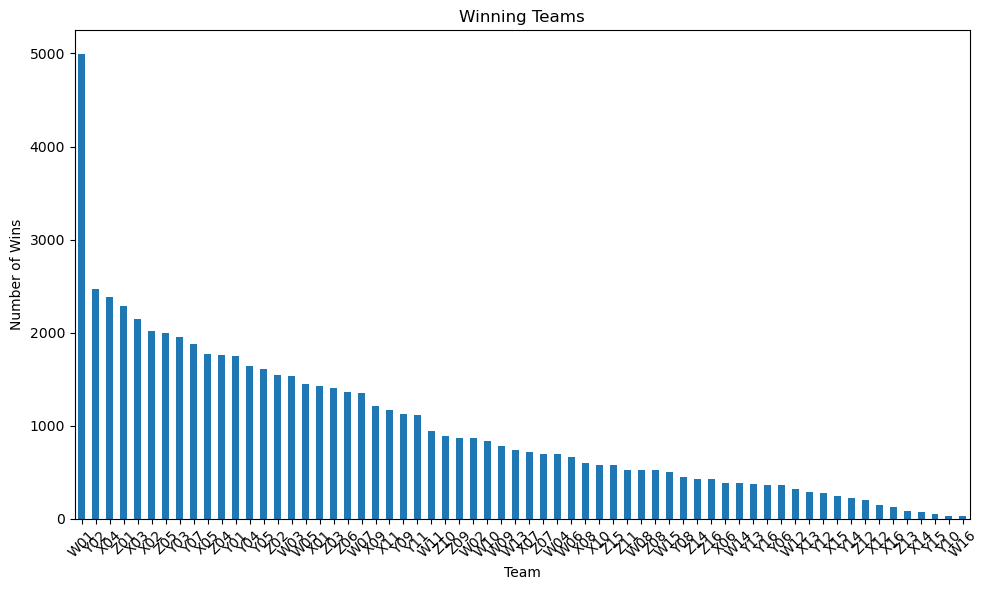

In [77]:
#winning_teams_counts = df_submission['Team'].value_counts()

plt.figure(figsize=(10, 6))
winning_teams_counts_men.plot(kind='bar')
plt.title('Winning Teams')
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
#!pip install --upgrade setuptools
#!pip install --upgrade binarytree
#!pip install bracketeer

from bracketeer import build_bracket

ModuleNotFoundError: No module named 'bracketeer'

In [79]:
seed_and_IDs = pd.read_csv('2024_tourney_seeds.csv')
seed_and_IDs

,Tournament,Seed,TeamID
0,M,W01,1163
1,M,W02,1235
2,M,W03,1228
3,M,W04,1120
4,M,W05,1361
...,...,...,...
123,W,Z12,3162
124,W,Z13,3267
125,W,Z14,3238
126,W,Z15,3263


In [80]:
TeamName_and_ID = pd.read_csv('MTeams.csv')
TeamName_and_ID

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2024
1,1102,Air Force,1985,2024
2,1103,Akron,1985,2024
3,1104,Alabama,1985,2024
4,1105,Alabama A&M,2000,2024
...,...,...,...,...
373,1474,Queens NC,2023,2024
374,1475,Southern Indiana,2023,2024
375,1476,Stonehill,2023,2024
376,1477,TX A&M Commerce,2023,2024


In [81]:

seeds_to_names = pd.merge(TeamName_and_ID, seed_and_IDs, on='TeamID', how='inner')

# Display the merged DataFrame
seeds_to_names = seeds_to_names[['TeamName', 'Seed']]

seeds_to_names


,TeamName,Seed
0,Akron,Y14
1,Alabama,X04
2,Arizona,X02
3,Auburn,W04
4,Baylor,X03
...,...,...
59,Vermont,Z13
60,WKU,Z15
61,Washington St,W07
62,Wisconsin,Z05


In [82]:
import pandas as pd

# Assuming you have the submission_men DataFrame loaded already

# Get the counts of winning teams
winning_teams_counts_men = submission_men['Team'].value_counts()

# Convert the Series to a DataFrame
winning_teams_counts_men_df = winning_teams_counts_men.to_frame().reset_index()

# Rename the columns
winning_teams_counts_men_df.columns = ['Seed', 'Number of Wins']

# Display the DataFrame
winning_teams_counts_men_df


,Seed,Number of Wins
0,W01,4999
1,Y02,2469
2,X04,2380
3,Z01,2286
4,X03,2142
...,...,...
59,Z13,81
60,X14,67
61,Y15,46
62,Y10,30


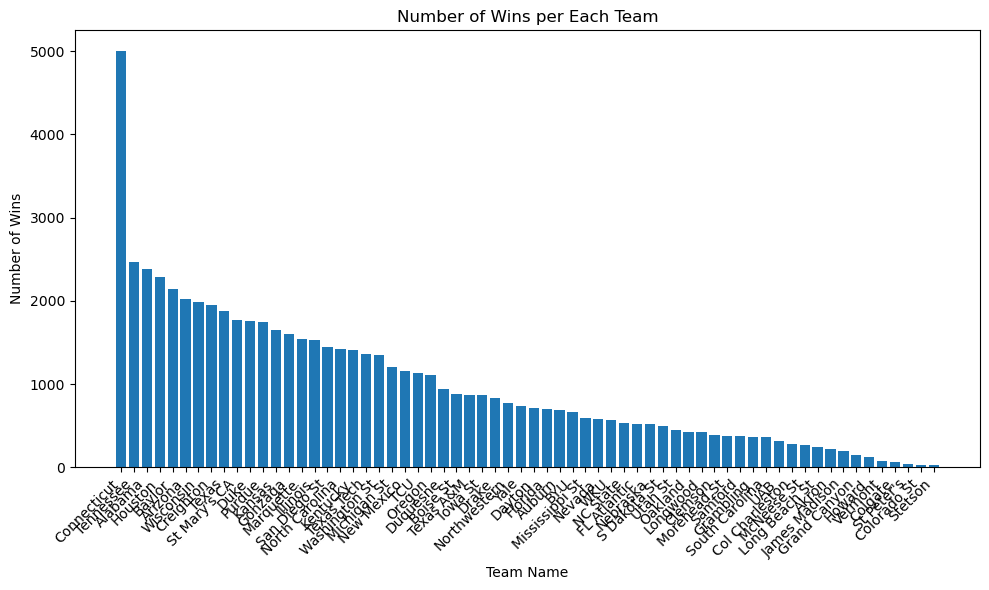

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have seeds_to_names and winning_teams_counts_men_df DataFrames loaded already

# Merge the DataFrames on the 'Seed' column
merged_data = pd.merge(seeds_to_names, winning_teams_counts_men_df, on='Seed', how='inner')

# Sort the merged DataFrame by 'Number of Wins' in descending order
merged_data_sorted = merged_data.sort_values(by='Number of Wins', ascending=False)

# Plot the number of wins associated with each team name
plt.figure(figsize=(10, 6))
plt.bar(merged_data_sorted['TeamName'], merged_data_sorted['Number of Wins'])
plt.xlabel('Team Name')
plt.ylabel('Number of Wins')
plt.title('Number of Wins per Each Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
submission.to_csv('submission.csv')